<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#a)-posterior-speed" data-toc-modified-id="a)-posterior-speed-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>a) posterior speed</a></span></li><li><span><a href="#b)-confidence-intervals" data-toc-modified-id="b)-confidence-intervals-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>b) confidence intervals</a></span></li><li><span><a href="#c)-same-speed" data-toc-modified-id="c)-same-speed-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>c) same speed</a></span></li><li><span><a href="#d)-reduced-data-set" data-toc-modified-id="d)-reduced-data-set-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>d) reduced data set</a></span></li></ul></div>

In [1]:
import pandas
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pymc3 as pm
import arviz as az

Load in data from location_data_hw8_2022.csv.

Since no units are given, I'm assuming position is measured in meters and time is measured in seconds.

In [2]:
fname = 'location_data_hw8_2022.csv'
data = pandas.read_csv(fname)

Visualize the data:

Text(0, 0.5, 'y position (m)')

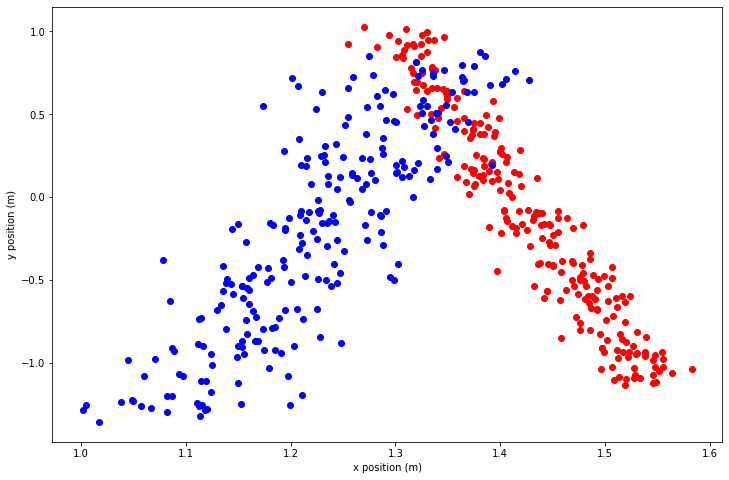

In [3]:
# plot the x, y position
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()

ax.scatter(data["red_pos_X"], data["red_pos_Y"], c="r")
ax.scatter(data["blue_pos_X"], data["blue_pos_Y"], c="b")
ax.set_xlabel("x position (m)")
ax.set_ylabel("y position (m)")

### a) posterior speed

"Assume both objects move at a fixed speed/direction, and assume that there is a fixed measurement error (ie., the observed location in x,y is the true location plus some i.i.d. Gaussian random noise at time t)."

-----

I'm going to work through this for just the x component of the red object first to make sure I understand what the MCMC functions are doing.



The observed x location at each time x(t) is the sum of (1) velocity in the x direction V_x * time, (2) constant offset at t=0 in the x direction c_x, and (3) normally distributed errors with mean 0 and variance sd2_x:

    x(t) = V_x * t + c_x + e(0, sd2_x)

- x(t) and t are observed. 

- V_x, c_x, and sd2_x are fit parameters. To start, assume these all have uniform (or uninformative) priors; get reasonable ranges from the data?

- MCMC works better on zscored data; doesn't converge if I use raw x(t)

In [4]:
# 1: pull out observed time vector

t = np.array(data["t"])

In [5]:
# 2: zscore observed x location of red component

red_x = np.array(data["red_pos_X"])

red_x_mu = red_x.mean()
red_x_sd = red_x.std() # save this for later to transform MCMC outputs... 

red_x_norm = (red_x - red_x_mu) / red_x_sd

In [6]:
# 3: define model with pymc3

with pm.Model() as model:
    
    # define uniform priors
    v_x = pm.Uniform('v_x', -0.005, 0.005) # velocity in x direction
    c_x = pm.Uniform('c_x', -5, 5) # constant offset in x direction
    sd2_x = pm.Uniform('sd2_x', 0, 5) # variance of gauss error in x direction
   
    # define distribution over observations of x
    X = pm.Normal("X", v_x * t + c_x, sd2_x, observed=red_x_norm)


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd2_x, c_x, v_x]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8805355228867638, but should be close to 0.8. Try to increase the number of tuning steps.


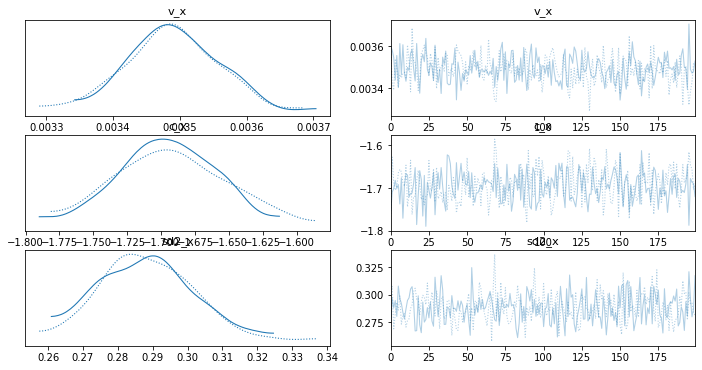

In [7]:
# 4: run MCMC

with model:
    step = pm.NUTS()
    trace = pm.sample(2000, 
                      step = [step], 
                      cores=2, 
                      return_inferencedata=False)
    
# quickly show posteriors for each parameter as a sanity check
with model:
    _ = az.plot_trace(trace[1000:][::5])

Text(0, 0.5, 'P(velocity of x)')

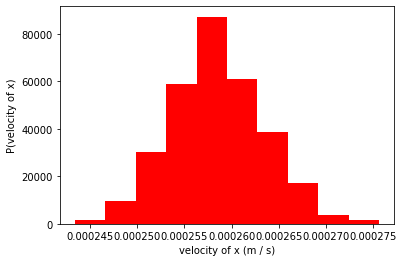

In [8]:
# 5: show posterior of velocity in x direction; "undo" zscoring to 
# make these values more interpretable (i.e. multiply MCMC posterior 
# distribution over velocity by the standard deviation of the raw x
# position (red_x_sd))

fig = plt.figure()
ax = fig.add_subplot()

ax.hist(red_x_sd * trace["v_x"][1000:][::5], 
        density=True,
        label="red x velocity",
        color="r")

ax.set_xlabel("velocity of x (m / s)")
ax.set_ylabel("P(velocity of x)")


Text(0, 0.5, 'x position (m)')

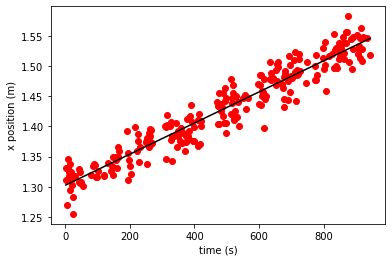

In [9]:
# 6: let's check if this is sensible with the original data...

# use median of posterior for each param
med_v = np.median(red_x_sd * trace["v_x"][1000:][::5]) # get median
med_c = np.median(trace["c_x"][1000:][::5])

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(t, red_x, c="r")
x_offset = med_c * red_x_sd + red_x_mu
ax.plot(t[[0, -1]], med_v * t[[0, -1]] + x_offset, c="k")

ax.set_xlabel("time (s)")
ax.set_ylabel("x position (m)")


Looks good! 

----

Now let's write a function that will perform this procedure so we can estimate the x and y velocities for both objects.

In [10]:
def get_MCMC_velocity(observed_t, observed_x):
    """
    From observed positions (in 1D) and times, use MCMC to estimate 
    the posterior of the velocity.
    
    Parameters
    ----------
    observed_t : np vector
        observed sample times 
    
    observed_x : np vecotr
        observed locations
    
    
    Returns
    -------
    velocity_dist : np vector
        histogram over this vector approximates the velocity posterior
        
    x_offset : np vector
        corresponding position offsets at t=0 for each in velocity_dist
        
    """
    # (1: pull out observed time vector -- already done!)

    # 2: zscore observed location
    x_mu = observed_x.mean()
    x_sd = observed_x.std()
    
    x_norm = (observed_x - x_mu) / x_sd
    
    # 3: define model with pymc3
    with pm.Model() as model:
    
        # define uniform priors
        v = pm.Uniform('v', -0.005, 0.005) # velocity in x direction
        c = pm.Uniform('c', -5, 5) # constant offset in x direction
        sd2 = pm.Uniform('sd2', 0, 5) # variance of gauss error in x direction
   
        # define distribution over observations of x
        X = pm.Normal("X", v * observed_t + c, sd2, observed=x_norm)
        
    # 4: run MCMC
    with model:
        step = pm.NUTS()
        trace = pm.sample(2000, 
                          step = [step], 
                          cores=2, 
                          return_inferencedata=False)
        
    # 5: return velocity posterior; "undo" zscoring of x
    velocity_dist = x_sd * trace["v"][1000:][::5]
    
    # 6: let's also spit out the position offset at t=0, just in
    # case we want to visualize the position later...
    x_offset = x_sd * trace["c"][1000:][::5] + x_mu
    
    return velocity_dist, x_offset


# compute!
V_red_x, off_red_x = get_MCMC_velocity(t, np.array(data["red_pos_X"]))
V_red_y, off_red_y = get_MCMC_velocity(t, np.array(data["red_pos_Y"]))
                            
V_blue_x, off_blue_x = get_MCMC_velocity(t, np.array(data["blue_pos_X"]))
V_blue_y, off_blue_y = get_MCMC_velocity(t, np.array(data["blue_pos_Y"]))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd2, c, v]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8791810359164974, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd2, c, v]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 16 seconds.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd2, c, v]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 15 seconds.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd2, c, v]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 16 seconds.


Let's check our work: estimate the distribution of true positions from the velocity posteriors and compare to the observed data.

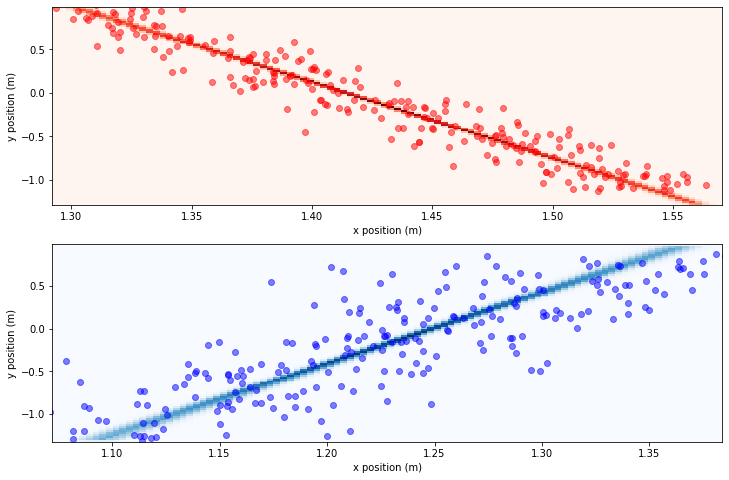

In [11]:
def show_position_estimate(t, V_x, V_y, off_x, off_y, ax, cmap):
    """
    Estimate the true object position from the velocity 
    posteriors; show with 2D hist
    
    Paramters
    ---------
    t : np vector
        time points to calculate estimate
    V_x : np vector
        MCMC samples of velocity in x direction
    V_y : np vector
        MCMC samples of velocity in y direction
    off_x : np vector
        constant offset in x direction, for each V_x
    off_y : np vector
        constant offset in y direction, for each V_y
    ax : plt subplot
        subplot for 2D hist of x, y position
    color : "r" or "b"
        object color
        
    Returns
    -------
    x_guess : np array
        estimated x position, for each MCMC sample x time
    y_guess : np array
        estimated y position, for each MCMC sample x time
    
    """
    
    nt = np.max(t.shape) # number of time points
    ns = np.max(V_x.shape) # number of MCMC samples
    
    # reshape vectors for matmul
    t_row = t.reshape((1, nt))
    V_x_col = V_x.reshape((ns, 1))
    V_y_col = V_y.reshape((ns, 1))
    off_x_col = off_x.reshape((ns, 1))
    off_y_col = off_y.reshape((ns, 1))
    
    # get the x, y positions for each MCMC sample
    x_guess = np.matmul(V_x_col, t_row) + off_x_col
    y_guess = np.matmul(V_y_col, t_row) + off_y_col
    
    # let's make a 2D histogram!
    ax.hist2d(x_guess.flatten(), y_guess.flatten(), 
              bins = 100, cmap=cmap)
    ax.set_xlabel('x position (m)')
    ax.set_ylabel('y position (m)')

    return x_guess, y_guess
    
# compare estimates with observed data   
t = np.linspace(0, 999, 1000)

fig = plt.figure(figsize=(12, 8))

ax_r = fig.add_subplot(2, 1, 1)
red_x_guess, red_y_guess = show_position_estimate(t, V_red_x, V_red_y, 
                       off_red_x, off_red_y, 
                       ax_r, "Reds")
ax_r.scatter(data["red_pos_X"], data["red_pos_Y"], 
             c="r", alpha=0.5)


ax_b = fig.add_subplot(2, 1, 2)
blue_x_guess, blue_y_guess = show_position_estimate(t, V_blue_x, V_blue_y, 
                       off_blue_x, off_blue_y, 
                       ax_b, "Blues")
ax_b.scatter(data["blue_pos_X"], data["blue_pos_Y"], 
             c="b", alpha=0.5)


**Finally, show the posterior distributions for speed of each object:**

(changed units to cm / s to make x axis more legible)

Text(0, 0.5, 'P(blue speed)')

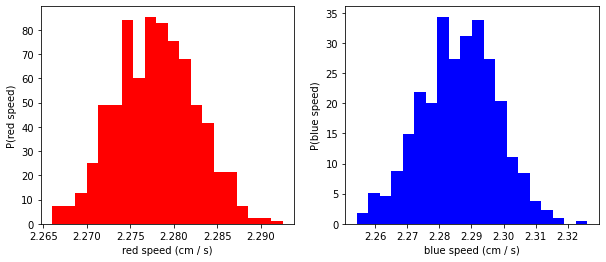

In [12]:
fig = plt.figure(figsize=(10, 4))

ax_r = fig.add_subplot(1, 2, 1)
red_speed = np.sqrt(V_red_x ** 2 + V_red_y ** 2) * 1000
ax_r.hist(red_speed, color="r", density=True, bins=20)
ax_r.set_xlabel("red speed (cm / s)")
ax_r.set_ylabel("P(red speed)")

ax_b = fig.add_subplot(1, 2, 2)
blue_speed = np.sqrt(V_blue_x ** 2 + V_blue_y ** 2) * 1000
ax_b.hist(blue_speed, color="b", density=True, bins=20)
ax_b.set_xlabel("blue speed (cm / s)")
ax_b.set_ylabel("P(blue speed)")


### b) confidence intervals

"What is the 5% and 95% confidence interval of the time range when the true Y value of the Blue object is => 0 AND the true Y value of Red <=0? That is, what are the 5% and 95% quantiles of the estimated first time when Y_blue >= 0 and Y_red <= 0?"

Text(0, 0.5, 'y position (m)')

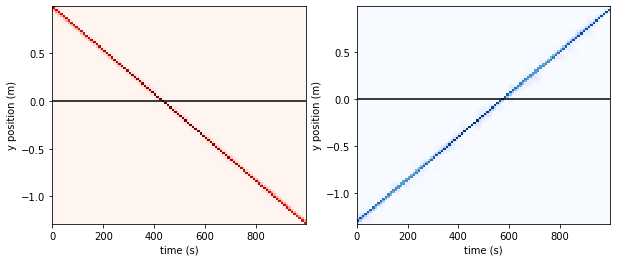

In [17]:
# show estimates of true y positions
t_mat = np.tile(t.reshape((1, 1000)), (red_y_guess.shape[0], 1))

fig = plt.figure(figsize=(10, 4))

ax = fig.add_subplot(1, 2, 1)
ax.hist2d(t_mat.flatten(), red_y_guess.flatten(), 
          bins = 100, cmap="Reds")
ax.scatter(data["t"], data["red_pos_Y"], c="r", alpha=.01)
ax.plot([0, 1000], [0, 0], c="k")
ax.set_xlabel('time (s)')
ax.set_ylabel('y position (m)')


ax = fig.add_subplot(1, 2, 2)
ax.hist2d(t_mat.flatten(), blue_y_guess.flatten(), 
          bins = 100, cmap="Blues")
ax.scatter(data["t"], data["blue_pos_Y"], c="b", alpha=.01)
ax.plot([0, 1000], [0, 0], c="k")
ax.set_xlabel('time (s)')
ax.set_ylabel('y position (m)')

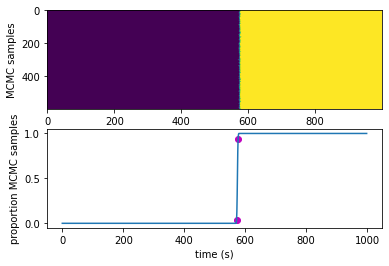

In [18]:
# for each MCMC sample, show when blue y > 0 and red y < 0:
condition = np.logical_and(blue_y_guess > 0, red_y_guess < 0)

fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.imshow(condition)
ax1.set_aspect('auto')
ax1.set_ylabel('MCMC samples')

ax2 = fig.add_subplot(2, 1, 2)
prop_true = np.mean(condition, axis=0)
ax2.plot(t, prop_true)
ax2.set_xlabel("time (s)")
ax2.set_ylabel("proportion MCMC samples")

# find 5% and 95% interval for time: 
t05 = np.argmin(np.abs(prop_true - 0.05))
t95 = np.argmin(np.abs(prop_true - 0.95))

ax2.scatter(t[[t05, t95]], prop_true[[t05, t95]], c="m")

**The 5% and 95% confidence interval of the 1st time when blue y > 0 and red y < 0:**

In [19]:
print(f"[{t05}, {t95}] sec")

[572, 577] sec


### c) same speed

"If both objects are known to be moving at the same speed, how does you answer in a and b change? That is, that the total magnitude of the velocity (sqrt[vx^2 + vy^2]) is the same for each object."

This is another way to write the relationship between overall speed and individual x and y velocities:

    v_y = speed * cos(theta)
    v_x = speed * sin(theta)

We will assume that the red and blue object have the same overall speed, but possibly different thetas: *(these are the parameters we're ultimately interested in)*

    speed = pm.Uniform('speed', 0, 0.01) # same speed for both objects
    theta_red = pm.Uniform('theta_red', 0, 2*np.pi) # angle for red object
    theta_blue = pm.Uniform('theta_blue, 0, 2*np.pi) # angle for blue object
    
We'll want to fit the (normalized) observed x, y data from both object at the same time:
    
    X_red = pm.Normal('X_red', speed * np.cos(theta_red) * t + c_x_red, 
                      sd2_x_red, observed=x_red_norm)
    Y_red = pm.Normal('Y_red', speed * np.sin(theta_red) * t + c_y_red, 
                    sd2_y_red, observed=y_red_norm)
    X_blue = pm.Normal('X_blue', speed * np.cos(theta_blue) * t + c_x_blue, 
                       sd2_x_blue, observed=x_blue_norm)
    Y_red = pm.Normal('Y_blue', speed * np.sin(theta_blue) * t + c_y_blue, 
                    sd2_y_blue, observed=y_blue_norm)
     
That means we also need to define priors for constant offsets c and variance of noise sd2, which are indepedent for each color and direction: *(we need these parameters to be flexible, but we aren't really interested in examining them)*
    
    c_x_red = pm.Uniform('c_x_red', -1, 1)
    c_y_red = pm.Uniform('c_y_red', -1, 1)
    c_x_blue = pm.Uniform('c_x_blue', -1, 1)
    c_y_blue = pm.Uniform('c_y_blue', -1, 1)
    sd2_x_red = pm.Uniform('sd2_x_red', 0, 1)
    sd2_y_red = pm.Uniform('sd2_y_red', 0, 1)
    sd2_x_blue = pm.Uniform('sd2_x_blue', 0, 1)
    sd2_y_blue = pm.Uniform('sd2_y_blue', 0, 1)

Let's see if we can run an MCMC model with all of these parameters at the same time...

In [20]:
def get_MCMC_velocity_onespeed(data):
    """
    Assume the red and blue object have the same speed. From observed x, y positions (in 1D) 
    and times, use MCMC to estimate that speed (and the x and y velocities for each object).
    
    Parameters
    ----------
    data : pandas table
        expected columns = "t", "red_pos_X", "red_pos_Y", "blue_pos_X", "blue_pos_Y"

    
    Returns
    -------
    speed_dist : np vector
        histogram over this vector approximates the speed posterior
    
        
    """
    # (1: pull out observed time vector -- already done!)
    t = np.array(data["t"])
    
    # 2: zscore observed positions
    pos_mu = data.iloc[:, 1:].mean()
    pos_sd = data.iloc[:, 1:].std() # save for later...
    
    red_x_norm = stats.zscore(data["red_pos_X"])
    red_y_norm = stats.zscore(data["red_pos_Y"])
    blue_x_norm = stats.zscore(data["blue_pos_X"])
    blue_y_norm = stats.zscore(data["blue_pos_Y"])
    
    # 3: define model with pymc3
    with pm.Model() as model:
    
        # define uniform priors for variables we're interested in
        speed = pm.Uniform('speed', 0, 0.01) # same speed for both objects
        theta_red = pm.Uniform('theta_red', 0, 2*np.pi) # angle for red object
        theta_blue = pm.Uniform('theta_blue', 0, 2*np.pi) # angle for blue object
                        
        # define uniform priors for variables we're less interested in      
        c_x_red = pm.Uniform('c_x_red', -1, 1) # constant offsets
        c_y_red = pm.Uniform('c_y_red', -1, 1)
        c_x_blue = pm.Uniform('c_x_blue', -1, 1)
        c_y_blue = pm.Uniform('c_y_blue', -1, 1)
        sd2_x_red = pm.Uniform('sd2_x_red', 0, 1) # variance of gauss error
        sd2_y_red = pm.Uniform('sd2_y_red', 0, 1)
        sd2_x_blue = pm.Uniform('sd2_x_blue', 0, 1)
        sd2_y_blue = pm.Uniform('sd2_y_blue', 0, 1)            
   
        # define distribution over observations 
        X_red = pm.Normal('X_red', speed * np.cos(theta_red) * t + c_x_red, 
                          sd2_x_red, observed=red_x_norm)
        Y_red = pm.Normal('Y_red', speed * np.sin(theta_red) * t + c_y_red, 
                        sd2_y_red, observed=red_y_norm)
        X_blue = pm.Normal('X_blue', speed * np.cos(theta_blue) * t + c_x_blue, 
                           sd2_x_blue, observed=blue_x_norm)
        Y_red = pm.Normal('Y_blue', speed * np.sin(theta_blue) * t + c_y_blue, 
                        sd2_y_blue, observed=blue_y_norm)
        
    # 4: run MCMC
    with model:
        step = pm.NUTS()
        trace = pm.sample(4000, # let's try more, bc model has so many params
                          step = [step], 
                          cores=2, 
                          return_inferencedata=False)
        
    # 5: return velocity posterior; "undo" zscoring 
    scale = np.sqrt(pos_sd["red_pos_X"] ** 2 + pos_sd["red_pos_Y"] ** 2)
    speed_dist = scale * trace["speed"][1000:][::5]
    
    return speed_dist


# compute!
speed_dist = get_MCMC_velocity_onespeed(data)
print(np.median(speed_dist))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd2_y_blue, sd2_x_blue, sd2_y_red, sd2_x_red, c_y_blue, c_x_blue, c_y_red, c_x_red, theta_blue, theta_red, speed]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 37 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


0.0021222279421528366


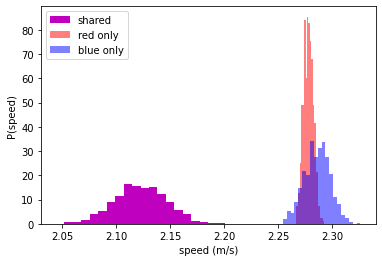

In [21]:
# show posterior of speed (assumed same for red and blue)
fig = plt.figure()
ax = fig.add_subplot()
ax.hist(1000*speed_dist, color="m", density=True, bins=20)

# overlay speed distribtutions computed independently in part (a) for comparison
ax.hist(red_speed, color="r", alpha=0.5, density=True, bins=20)
ax.hist(blue_speed, color="b", alpha=0.5, density=True, bins=20)

ax.set_xlabel('speed (m/s)')
ax.set_ylabel('P(speed)')

ax.legend(['shared','red only','blue only'])




**If I assume the red and blue objects are moving at the same speed, the posterior distribution (purple) is slower and more broadly distributed than when I estimate the speeds independently (red and blue, from part a).**

This is somewhat surprising, since the independent estimates of the red and blue object speeds are so similar. My first guess would be that this posterior is more strongly influenced by the priors, since there are many more free parameters to estimate in the shared model, but the same amount of observed data. If I had more time I would explore how different priors influence this estimate of speed.

I'm also suspicious of my giant model with 11 (!!) parameters. I suspect there is a more efficient way to solve this problem...

I tried another version where I assumed the observation noise was always the same (so same gauss for x and y, red and blue), which allowed me to remove 3 parameters but the speed posterior was essentially the same.

### d) reduced data set